# Zurich open data exploration

## Reading csv, json and shape format datasets. Combining them into one central file, and visualizing some elements.

One of the goals of our project is to study urban environment of Zurich city and afterwards associate it with insurance data. For this purpose, we will be utilizing public datasets published on <a href="url">https://data.stadt-zuerich.ch/</a> website. Datasets we will be using contain, but are not limited to, public parks, schools, street lights, public WCs and etc. in Zurich. 

This notebook is used to load all relevant datasets found on https://data.stadt-zuerich.ch/ as well as the population per zip code data from https://opendata.swiss/en/dataset/bevoelkerung-pro-plz into a central file that will be used for the rest of the analysis.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from os import listdir
import matplotlib.pyplot as plt

In [2]:
DATA_FOLDER = "./data/"
CSV_JSON_FOLDER = DATA_FOLDER + './csv_json_files/'
SHAPE_FOLDER = DATA_FOLDER + "shapeFiles/"

## Reading and loading the csv files

In [3]:
# create function that reads cleans and appends csv to the general dataframe
def csv_read_clean_append(csv_file, duplicate_check, group_on, new_column, append_target=None):
    
    # load csv into dataframe, drop any duplacte rows, count values for group_on series 
    temp_df = pd.read_csv(CSV_JSON_FOLDER + csv_file).drop_duplicates(duplicate_check)[group_on].value_counts().to_frame(new_column)
    
    if append_target is None:
        return temp_df
    else:
        return append_target.join(temp_df)

In [4]:
# start with addresses and number of hospitality companies
combined_df = csv_read_clean_append('adressen.csv', 'adresse', 'plz', 'addresses')
combined_df = csv_read_clean_append('gastwirtschaftsbetriebe_per_20171231.csv',\
                                    'Betriebsname', 'plz', 'hospitality_companies', combined_df)

We now insert the population per zip code. We have to do some manual touching up, as the population is a sum of number of women and men.

In [5]:
# read population per zip code file
population_df = pd.read_csv(CSV_JSON_FOLDER +'bevoelkerung_proplz.csv',delimiter=';')

# sum the men and women count per zip code to get population per zip code
population_df = population_df[population_df['typ']\
                                .isin(['w', 'm'])]\
                                .groupby('plz')['anzahl']\
                                .agg('sum')\
                                .to_frame('population')

# merge the population data to the rest
combined_df = pd.merge(combined_df, population_df, 'inner', left_index=True, right_index=True)
combined_df.head()

,addresses,hospitality_companies,population
8050,4134,153.0,34412
8049,3498,34.0,27853
8048,3492,95.0,33499
8032,3403,50.0,23866
8046,3016,31.0,29139


## Reading and loading the json files

In [6]:
# create function that reads cleans and appends json datasets to the general dataframe
def json_read_clean_append(json_file, duplicate_check, group_on, new_column, append_target=None):
    
    # first read json using geopandas
    temp_df = gpd.read_file(CSV_JSON_FOLDER + json_file)
    
    
    # load json into dataframe, drop any duplicate rows, count values for group_on series 
    temp_df = pd.DataFrame(temp_df).drop_duplicates(duplicate_check)[group_on].value_counts().to_frame(new_column)
    temp_df.index = pd.to_numeric(temp_df.index)
    
    if append_target is None:
        return temp_df
    else:
        return pd.merge(append_target, temp_df, 'left', left_index=True,right_index=True)

In [7]:
# loop through json files in data folder and add to general df with function above
for file in listdir(CSV_JSON_FOLDER):
    if file.endswith('.json'):
        combined_df = json_read_clean_append(file,'adresse', 'plz', file[:-5], combined_df)

## Reading and loading the shape files

Shape files contain spatial information in form of point coordinates (longitude and latitude). In order to identify to which postal code they belong, we will be using zips.shp file that contains polygons describing area of zip codes in Switzerland. Furthermore, we will utilize geopandas functionality to join points with zip codes. One should also pay special attention to coordinate sysem. In order to join correctly all shape files should agree on coordinate system. Therefore, we will take coordinate systems used in zips.shp file as default and convert any other one into it for consistency.

In [8]:
#read zips data
zips = gpd.read_file(SHAPE_FOLDER + "zips.shp")
zips.columns = ['UUID', 'OS_UUID', 'STATUS', 'INAEND', 'ZIP', 'ZUSZIFF','geometry']

#default coordinate system
COORDINATE_SYSTEM = zips.crs
print("used coordinate system: ", zips.crs)

used coordinate system:  {'init': 'epsg:4326'}


Now we define method to read shape files into dataframe, to remove duplicates and convert coordinates to default coordinate system.

In [9]:
#default coordinate system
COORDINATE_SYSTEM = {'init': 'epsg:4326'}

def read_shape_file(file_name):
    df = gpd.read_file(SHAPE_FOLDER + file_name)
    
    #drop duplicates
    G = df["geometry"].apply(lambda geom: geom.wkb)
    df = df.loc[G.drop_duplicates().index]
    
    #convert to default coordinate systen
    if (df.crs != COORDINATE_SYSTEM):
        df = df.to_crs(COORDINATE_SYSTEM)
    
    return df

Furthermore, we define method that joins points with corresponding polygons. Meaning we will much each coordinate (longitute and latitude) with corresponding zip code in Zurich and then groups counts by zip code.

In [10]:
def join_points_with_zips(df):
    """join coordinates with zip codes"""
    pointInPoly = gpd.sjoin(df, zips, op='within') 
    return pointInPoly

In [11]:
def grouping_by_zipcode(df, new_column):
    """group item counts per zip codes"""
    df = df.groupby('ZIP').size().reset_index(name=new_column)
    df.set_index('ZIP', inplace=True)
    return df

The method below will be used for appending information in the shape file to the existing central dataframe for aggregation of all information into one file.

In [12]:
# create function that reads cleans and appends shape datasets to the general dataframe
def shape_read_clean_append(shape_file, new_column, append_target=None):
    
    # first read shape, drop duplicates
    temp_df = read_shape_file(shape_file)
    
    temp_df = join_points_with_zips(temp_df)
    
    # load shape into dataframe, drop any duplicate rows, count values for group_on series 
    temp_df = grouping_by_zipcode(temp_df, new_column)
    temp_df.index = pd.to_numeric(temp_df.index)
    #display(temp_df.head(2))
    
    if append_target is None:
        return temp_df
    else:
        return pd.merge(append_target, temp_df, 'left', left_index=True,right_index=True)

Now we will read all shape files from corresponding folder and load them into the central dataframe.

In [13]:
# loop through shp files in data folder and add to general df with function above
for file in listdir(SHAPE_FOLDER):
    if file.endswith('.shp'):
        combined_df = shape_read_clean_append(file, file[:-4], combined_df)

("External Dataset Preprocessing.ipynb" contains some additional information about shape files)

## Final Merging

At the end we save combined information into .csv file for further usage.

In [14]:
# drop zip codes that are not used (last 5 rows), and fill other nans with zeros
combined_df = combined_df.dropna(subset=['hospitality_companies']).fillna(0)
combined_df.to_csv(DATA_FOLDER + "open_data_aggregated.csv")
combined_df.head()

,addresses,hospitality_companies,population,publibike,indoor_pools,Mobility_rental,outdoor_pools,ice_rinks,police_locations,skate_parks,...,Beleuchtung,ZueriWC_rollstuhlgaengig,Park,KunstImStadtraum,Kindergarten,Brunnen,Sozialzentrum,Sporthalle,Picknickplatz,Jugendtreff
8050,4134,153.0,34412,6.0,1.0,18.0,0.0,1.0,2.0,0.0,...,2677,5.0,16.0,15.0,19.0,65.0,1.0,3.0,1.0,2.0
8049,3498,34.0,27853,0.0,1.0,10.0,0.0,0.0,1.0,0.0,...,2187,3.0,4.0,6.0,15.0,62.0,0.0,0.0,10.0,0.0
8048,3492,95.0,33499,5.0,1.0,11.0,1.0,0.0,1.0,1.0,...,2225,3.0,1.0,10.0,20.0,65.0,0.0,0.0,6.0,1.0
8032,3403,50.0,23866,4.0,1.0,13.0,0.0,0.0,1.0,0.0,...,1692,5.0,4.0,20.0,7.0,64.0,0.0,0.0,3.0,0.0
8046,3016,31.0,29139,0.0,0.0,7.0,0.0,0.0,1.0,1.0,...,1669,1.0,7.0,4.0,17.0,49.0,0.0,2.0,3.0,1.0


As we see datasets we will be using consists of:

- Addresses - 57923 in total
- Hospitality companies - 2097 in total
- Population - 509285 in total
- Beach volleyball - 12 in total
- Bike Parks - 1 in total
- Care centers - 20 in total
- Community centers - 18 in total
- Elementary schools - 115 in total
- Football fields - 15 in total
- Ice rinks - 3 in total
- Indoor pools - 7 in total
- Kindergartens - 241 in total
- Mobility rental - 227 in total
- Nurseries - 316 in total
- Outdoor pools - 6 in total
- Police locations - 28 in total
- Skate parks - 8 in total
- Tennis courts - 8 in total
- Parks - 118 in total
- Street Lights (Beleuchtung) - 40010 in total
- Old people center (Alterszentrum) - 28 in total
- Retirment houses (Alterswohnung) - 36 in total
- Handicapped parking (Behindertenparkplatz) - 410 in total
- Fontaines (brunnen) - 1281 in total
- Youth clubs/centers/ meeting center (Jugendtreff) - 13 in total
- Kindergarten - 354 in total
- Kinderhaus / Eltern-Kind-Zentrum - 16 in total
- Churches (Kirche) - 82 in total
- Temporary art in the urban space (Kunst im Stadtraum) - 388 in total
- picknickplatz - 110 in total
- social center (sozial zentrum) - 5 in total
- Gym (Sporthalle) - 16 in total
- Stadium - 1 in total (therefore won't be using, unless for combined sports metric)
- WC handicapped - 28 in total
- WC not handicapped - 77 in total

## Creating aggregated and normalized features

We combine features to create the following columns: sports_facilities, child_facilities, elderly_facilities, parks, toilets, handicapped_facilities (handicapp), transport_rental, community_facilities

In [19]:
combined_df.columns

Index(['addresses', 'hospitality_companies', 'population', 'publibike',
       'indoor_pools', 'Mobility_rental', 'outdoor_pools', 'ice_rinks',
       'police_locations', 'skate_parks', 'elementary_schools', 'nurseries',
       'football_fields', 'kindergartens', 'tennis_courts', 'bikeparks',
       'community_centers', 'care_centers', 'beachvolleyball', 'Stadion',
       'Kinderhaus', 'ZueriWC_nichtrollstuhlgaengig', 'Behindertenparkplatz',
       'Alterswohnung', 'zips', 'Alterszentrum', 'Kirche', 'Beleuchtung',
       'ZueriWC_rollstuhlgaengig', 'Park', 'KunstImStadtraum', 'Kindergarten',
       'Brunnen', 'Sozialzentrum', 'Sporthalle', 'Picknickplatz',
       'Jugendtreff'],
      dtype='object')

In [42]:
# aggregate features and rename others to english
aggregated_df = combined_df[['addresses', 'hospitality_companies', 'population','police_locations']]
aggregated_df = aggregated_df.assign(parks=combined_df[['Park', 'Picknickplatz']].sum(axis=1))

aggregated_df = aggregated_df.assign(sport_facilities=combined_df\
                                    [['indoor_pools', 'outdoor_pools','ice_rinks', 'skate_parks','football_fields',\
                                    'tennis_courts','bikeparks','beachvolleyball','Stadion', 'Sporthalle']].sum(axis=1))

aggregated_df = aggregated_df.assign(child_facilities=combined_df[['elementary_schools', 'nurseries','kindergartens',\
                                    'Kinderhaus']].sum(axis=1))

aggregated_df = aggregated_df.assign(elderly_facilities=combined_df[['care_centers', 'Alterswohnung','Alterszentrum']]\
                                     .sum(axis=1))

aggregated_df = aggregated_df.assign(toilets=combined_df[['ZueriWC_nichtrollstuhlgaengig', 'ZueriWC_rollstuhlgaengig']]\
                                     .sum(axis=1))

aggregated_df = aggregated_df.assign(handicapp=combined_df[['Behindertenparkplatz', 'ZueriWC_rollstuhlgaengig']]\
                                     .sum(axis=1))

aggregated_df = aggregated_df.assign(transport_rental=combined_df[['Mobility_rental', 'publibike']]\
                                     .sum(axis=1))

aggregated_df = aggregated_df.assign(community_facilities=combined_df[['community_centers', 'Jugendtreff']]\
                                     .sum(axis=1))


aggregated_df = aggregated_df.assign(fountains=combined_df['Brunnen'])
aggregated_df = aggregated_df.assign(street_art=combined_df['KunstImStadtraum'])
aggregated_df = aggregated_df.assign(social_centers=combined_df['Sozialzentrum'])
aggregated_df = aggregated_df.assign(street_lights=combined_df['Beleuchtung'])
aggregated_df = aggregated_df.assign(churches=combined_df['Kirche'])
aggregated_df.head()

,addresses,hospitality_companies,population,police_locations,parks,sport_facilities,child_facilities,elderly_facilities,toilets,handicapp,transport_rental,community_facilities,fountains,street_art,social_centers,street_lights,churches
8050,4134,153.0,34412,2.0,17.0,7.0,59.0,3.0,6.0,41.0,24.0,3.0,65.0,15.0,1.0,2677,2.0
8049,3498,34.0,27853,1.0,14.0,2.0,35.0,3.0,4.0,15.0,10.0,1.0,62.0,6.0,0.0,2187,2.0
8048,3492,95.0,33499,1.0,7.0,11.0,46.0,4.0,3.0,35.0,16.0,2.0,65.0,10.0,0.0,2225,4.0
8032,3403,50.0,23866,1.0,7.0,1.0,32.0,3.0,5.0,16.0,17.0,1.0,64.0,20.0,0.0,1692,2.0
8046,3016,31.0,29139,1.0,10.0,5.0,36.0,4.0,2.0,12.0,7.0,2.0,49.0,4.0,0.0,1669,3.0


In [43]:
# normalizing by population
pop_normed_df = aggregated_df.div(aggregated_df.population, axis=0).drop(columns='population')
pop_normed_df.head()

,addresses,hospitality_companies,police_locations,parks,sport_facilities,child_facilities,elderly_facilities,toilets,handicapp,transport_rental,community_facilities,fountains,street_art,social_centers,street_lights,churches
8050,0.120133,0.004446,0.000058,0.000494,0.000203,0.001715,0.000087,0.000174,0.001191,0.000697,0.000087,0.001889,0.000436,0.000029,0.077793,0.000058
8049,0.125588,0.001221,0.000036,0.000503,0.000072,0.001257,0.000108,0.000144,0.000539,0.000359,0.000036,0.002226,0.000215,0.000000,0.078519,0.000072
8048,0.104242,0.002836,0.000030,0.000209,0.000328,0.001373,0.000119,0.000090,0.001045,0.000478,0.000060,0.001940,0.000299,0.000000,0.066420,0.000119
8032,0.142588,0.002095,0.000042,0.000293,0.000042,0.001341,0.000126,0.000210,0.000670,0.000712,0.000042,0.002682,0.000838,0.000000,0.070896,0.000084
8046,0.103504,0.001064,0.000034,0.000343,0.000172,0.001235,0.000137,0.000069,0.000412,0.000240,0.000069,0.001682,0.000137,0.000000,0.057277,0.000103


## Exploring some of the Zurich open data

In [44]:
#read zips data
zips = gpd.read_file(SHAPE_FOLDER + "zips.shp")
zips.columns = ['UUID', 'OS_UUID', 'STATUS', 'INAEND', 'ZIP', 'ZUSZIFF','geometry']

In [45]:
# extract only geometries and zips and join on zurich zips 
combined_df2 = combined_df
combined_df2 = pd.merge(combined_df2, zips[['ZIP', 'geometry']].set_index('ZIP'), 'inner', left_index=True,right_index=True)
combined_df2 = combined_df2.drop_duplicates('addresses')

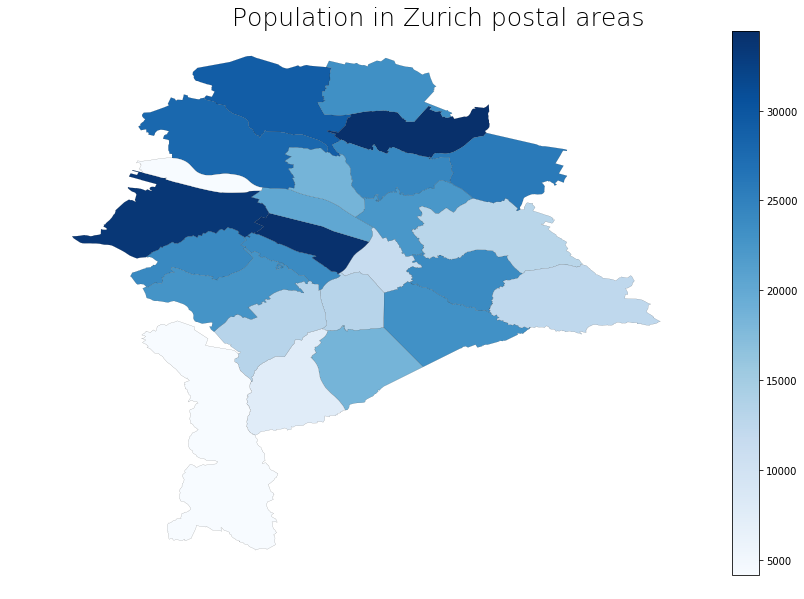

In [46]:
def plot_geopandas(gp, col_to_plot,title,colormap):
    '''
    This function creates a choropleth map using geopandas
    
    Parameters:
    gp = geodataframe data containing geometry column
    col_to_plot = column of data that must be plotted
    title = title of the map
    colormap = plt colormap to use, e.g. 'Blues', 'Accent', ...
    '''
    f, ax = plt.subplots(figsize=(15, 10))
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    # Create colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    
    # plotting settings
    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})
    ax.set_aspect('equal')
    cax.set_aspect('equal')
    cax.set_axis_off()
    ax.set_axis_off()

    # get preferred colormap
    cmap = plt.cm.get_cmap(colormap)
    
    # plot data
    gp.plot(column='population', ax=cax, linewidth=0.1, edgecolor='black',cmap=cmap)
    
    # create colorbar
    norm=plt.Normalize(vmin=gp[col_to_plot].min(), vmax=gp[col_to_plot].max())
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    sm._A = []
    f.colorbar(sm)
    
# use function defined above to create choropleth map 
plot_geopandas(gpd.GeoDataFrame(combined_df2), 'population', 'Population in Zurich postal areas','Blues')

As we can see, there is some disparity in population distribution around Zurich. The northern areas seem to be more residential areas, whereas the southern areas have relatively less residents. Let's now take a look at the areas with the most hospitalitys companies, i.e. bars, cafes, restaurants etc..

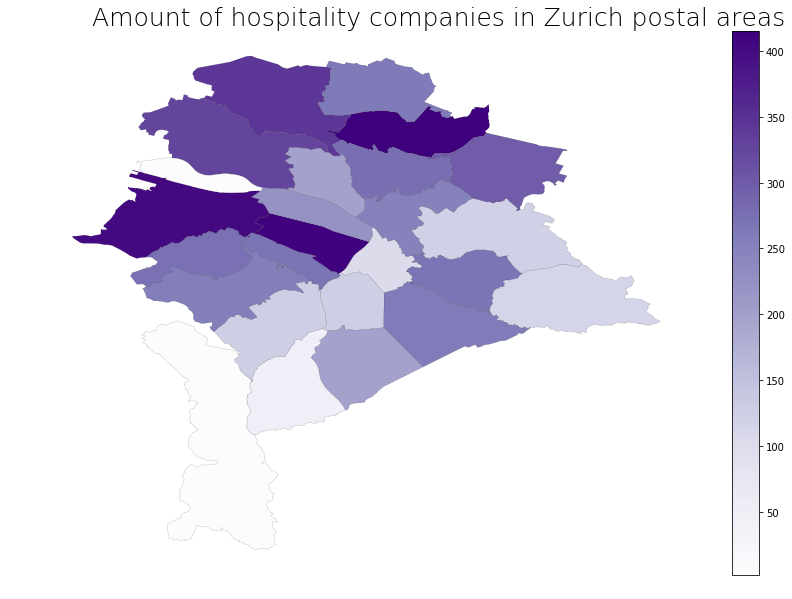

In [47]:
# use function defined above to create choropleth map 
plot_geopandas(gpd.GeoDataFrame(combined_df2), 'hospitality_companies',\
               'Amount of hospitality companies in Zurich postal areas','Purples')

We see here that the northern areas have more restaurants, bars etc.. This could be linked to the fact that more people live there, as seen previously. Let's also take a look at which areas have the most addresses, this could be an indication of building density.

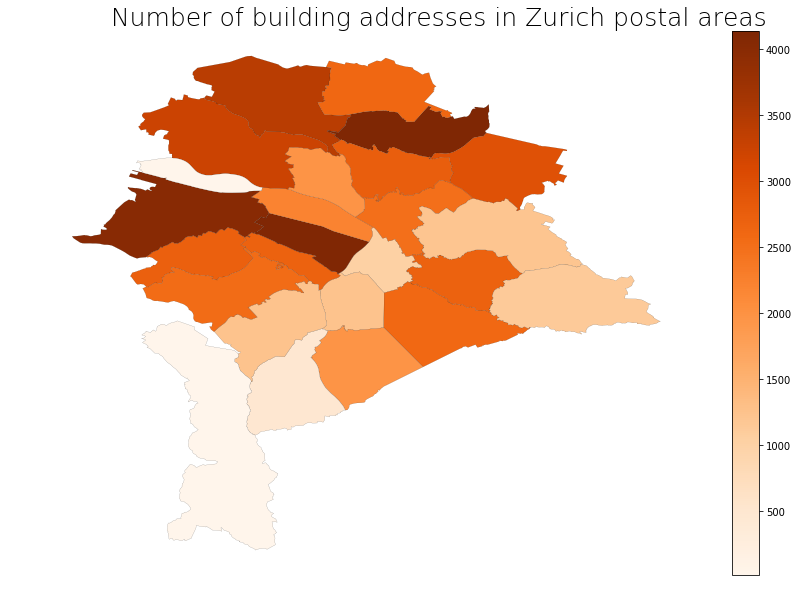

In [48]:
# use function defined above to create choropleth map 
plot_geopandas(gpd.GeoDataFrame(combined_df2), 'addresses',\
               'Number of building addresses in Zurich postal areas','Oranges')

Once again the same areas are highlighted. This brief exploration allows us to get an overview of the layout of Zurich, and how people and buildings are dispersed. A more detailed analysis is expected for the next milestone of our project.